In [1]:
if 'google.colab' in str(get_ipython()):
    !pip uninstall tensorflow -y
    !pip install tensorflow==2.3.1 tensorflow-quantum neptune-client
    !rm -rf quantum-gans
    !git clone https://github.com/WiktorJ/quantum-gans
    !cd quantum-gans; pip install .
    neptune_token = "" # put manually for the time being
else:
    import subprocess
    def get_var(varname):
        CMD = 'echo $(source ~/.bash_profile; echo $%s)' % varname
        p = subprocess.Popen(CMD, stdout=subprocess.PIPE, shell=True, executable='/bin/bash')
        return p.stdout.readlines()[0].strip()
    neptune_token = get_var('NEPTUNE_API_TOKEN').decode("utf-8") 

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import neptune
import tensorflow as tf
import random

import io
import cirq
import numpy as np
import statistics as st
from matplotlib import pyplot as plt
from collections import defaultdict
from qsgenerator import circuits
from qsgenerator.quwgans import circuits as quwgans_circuits
from qsgenerator.quwgans.circuits import get_discriminator
from qsgenerator.quwgans.training import Trainer
from qsgenerator.phase.circuits import PhaseCircuitBuilder
from qsgenerator.states.butterfly_circuits import ButterflyCircuitBuilder
from qsgenerator.quwgans.real_expectations_provider import PrecomputedExpectationsProvider, \
    Interpolation1DExpectationsProvider, WassersteinGanExpectationProvider, ExpectationProviderType
from qsgenerator.states.simple_rotation_generators import get_fixed_random_rotation_provider
from qsgenerator.evaluators.circuit_evaluator import CircuitEvaluator
from qsgenerator.phase.analitical import get_theta_v, get_theta_w, get_theta_r, get_g_parameters_provider


In [4]:
def get_expectation_provider(real, 
                             real_symbols, 
                             known_g_values, 
                             real_values_provider,
                             expectation_provider_type,
                             use_convolutions=False,
                             gen_input_dim=None,
                             hidden_dim=None,
                             penalty_factor=None,
                             gan_epochs=None,
                             batch_size=None,
                             n_crit=None,
                             alpha=None,
                             beta_1=None,
                             beta_2=None):
    precomputed_expectation_provider = PrecomputedExpectationsProvider(real,
                                                                       real_symbols,
                                                                       known_g_values,
                                                                       real_values_provider)
    if expectation_provider_type == ExpectationProviderType.ONLY_KNOWN:
        return precomputed_expectation_provider
    elif expectation_provider_type == ExpectationProviderType.INTERPOLATION1D:
        return Interpolation1DExpectationsProvider(precomputed_expectation_provider)
    elif expectation_provider_type == ExpectationProviderType.WGAN:
        return WassersteinGanExpectationProvider(precomputed_expectations_provider=precomputed_expectation_provider, 
                                                 gen_input_dim=gen_input_dim, 
                                                 hidden_dim=hidden_dim, 
                                                 penalty_factor=penalty_factor, 
                                                 epochs=gan_epochs, 
                                                 batch_size=batch_size, 
                                                 n_crit=n_crit,
                                                 use_neptune=use_neptune,
                                                 use_convolutions=use_convolutions,
                                                 alpha=alpha,
                                                 beta_1=beta_1,
                                                 beta_2=beta_2,
                                                 filter_small_expectations=False)

In [5]:
def start_neptune_experiment(use_neptune,
                             trainer, 
                             gen,
                             neptune_params,
                             gan_params,
                             description=None):
    if use_neptune:
        neptune.init(project_qualified_name='wiktor.jurasz/thesis-em-exps', api_token=neptune_token)
        if expectation_provider_type == ExpectationProviderType.WGAN:
            neptune_params = {**neptune_params, **gan_params}
        neptune.create_experiment(name=None, description=description, params=neptune_params)
        neptune.log_artifact(io.StringIO(str(gen)), "gen.txt")
        neptune.log_artifact(io.StringIO(str(([(el[0].numpy(), el[1], list(el[2].numpy())) for el in trainer.gen_weights]))), 'init_gen_weights.txt')

In [6]:
def compute_known_states_stats(tra, g_list):
       return compute_states_stats(
        lambda g: tra.real_evaluator.get_state_from_params(labels=g)[1],
        lambda g: tra.real_evaluator.get_state_from_params(labels=g)[1],
        g_list,
        g_list
    ) 

def compute_generated_states_stats(tra, g_list):
    return compute_states_stats(
        lambda g: tra.gen_evaluator.get_state_from_params()[1],
        lambda g: tra.real_evaluator.get_state_from_params(labels=g)[1],
        ["GENERATED"],
        g_list
    )

def compute_states_stats(state_prov1, state_prov2, g_list1, g_list2):
    stats = {
        'min_fidelity': 1,
        'min_fidelity_tuple': (None, None),
        'max_fidelity': 0,
        'max_fidelity_tuple': (None, None),
        'average_fidelity': None,
        'std_fidelity': None
    }
    fids = []
    for g1 in g_list1:
        for g2 in g_list2:
            if g1 != g2:
                state1 = state_prov1(g1)
                state2 = state_prov2(g2)
                fid = cirq.fidelity(state1, state2)
                fids.append(fid)
                if fid < stats['min_fidelity']:
                    stats['min_fidelity'] = fid
                    stats['min_fidelity_tuple'] = (g1, g2)
                if fid > stats['max_fidelity']:
                    stats['max_fidelity'] = fid
                    stats['max_fidelity_tuple'] = (g1, g2)
                
    stats['average_fidelity'] = st.mean(fids)
    stats['std_fidelity'] = st.stdev(fids)
    return stats


In [8]:
def run_for_g_values(g_values,
                     real,
                     real_symbols,
                     gen,
                     gs,
                     real_values_provider,
                     real_expectations_provider,
                     rank,
                     epochs,
                     gen_iteration, 
                     snapshot_interval_epochs,
                     description,
                     use_neptune,
                     neptune_params,
                     gan_params,
                     k,
                     trainers=None):
    if trainers is None:
        trainers = {}
    training_results = {}
    for g in g_values:
        
        trainers[g] = trainers.get(g, Trainer(real, 
                              real_symbols, 
                              gen, 
                              gs, 
                              [g], 
                              real_values_provider, 
                              real_expectations_provider,
                              rank=rank, 
                              k=k,
                              use_neptune=use_neptune))

        opt = tf.keras.optimizers.Adam(0.1, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

        start_neptune_experiment(use_neptune=use_neptune,
                                 trainer=trainers[g], 
                                 gen=gen,
                                 neptune_params=neptune_params,
                                 gan_params=gan_params,
                                 description=description)

        json_result =  trainers[g].train(opt=opt, 
                                         epochs=epochs, 
                                         gen_iteration=gen_iteration, 
                                         snapshot_interval_epochs=snapshot_interval_epochs, 
                                         plot=True)
        training_results[g] = json_result
    
        if use_neptune:
            neptune.stop()
    return trainers, training_results

In [ ]:
use_neptune = True
generator_layers = 3
data_bus_size = 4
rank = 1
k = 2
real_circuit_type = 'butterfly'
generic_generator = False
zxz = False
all_gates_parametrized = False
expectation_provider_type = ExpectationProviderType.WGAN
known_g_values = list(range(128))
# known_g_values = np.linspace(-1,0,31)
g_values = [1]

# only relevant if using WGAN provider
gen_input_dim = 16
hidden_dim = [32, 128]
penalty_factor = 10
gan_epochs = 3000
batch_size = 32
n_crit = 3
alpha: float = 0.005
beta_1: float = 0
beta_2: float = 0.9
use_convolutions: bool = False
        
gen_iteration = 1
snapshot_interval_epochs = 100
epochs = 401

description = None
# if expectation_provider_type == ExpectationProviderType.WGAN:
#     print(f"Expectations vector size: {9*((data_bus_size * (data_bus_size - 1))/2) + 3 * data_bus_size}")

In [78]:
neptune_params = {
            'generator_layers': generator_layers,
            'size':  data_bus_size,
            'rank': rank,
            'real_circuit_type': real_circuit_type,
            'generic_generator': generic_generator,
            'zxz': zxz,
            'all_gates_parametrized': all_gates_parametrized,
            'g_values': g_values,
            'expectation_provider_type': expectation_provider_type,
            'known_g_values': known_g_values,
            'gen_iteration': gen_iteration,
            'epochs': epochs,
            'k': k
        }

gan_params = {
                'gen_input_dim': gen_input_dim,
                'hidden_dim': hidden_dim,
                'penalty_factor': penalty_factor,
                'gan_epochs': gan_epochs,
                'batch_size': batch_size,
                'n_crit': n_crit,
                'alpha': alpha,
                'beta_1': beta_1,
                'beta_2': beta_2,
                'use_convolutions': use_convolutions 
            }

In [79]:
data_qubits = qubits = cirq.GridQubit.rect(1, data_bus_size)
if real_circuit_type == 'butterfly':
    real, real_symbols = ButterflyCircuitBuilder().build(qubits=qubits)
    real_values_provider = get_fixed_random_rotation_provider(len(real_symbols))
else:
    builder = PhaseCircuitBuilder(all_gates_parametrized=False)
    real, real_symbols, symbols_dict_real = builder.build_ground_state_circuit(qubits=data_qubits)
    real_values_provider = get_g_parameters_provider()

if generic_generator:
    gen, gs = circuits.build_circuit(generator_layers, data_qubits, "g")
    symbols_dict_gen = {}
else:
    if real_circuit_type == 'butterfly':
        gen, gs = ButterflyCircuitBuilder("g").build(qubits=qubits)
    else:
        builder = PhaseCircuitBuilder(all_gates_parametrized=all_gates_parametrized)
        gen, gs, symbols_dict_gen = builder.build_ground_state_circuit(qubits=data_qubits, full_parametrization=True, zxz=zxz)

real_expectations_provider = get_expectation_provider(real, 
                                                      real_symbols, 
                                                      known_g_values, 
                                                      real_values_provider,
                                                      expectation_provider_type,
                                                      use_convolutions=use_convolutions,
                                                      gen_input_dim=gen_input_dim,
                                                      hidden_dim=hidden_dim,
                                                      penalty_factor=penalty_factor,
                                                      gan_epochs=gan_epochs,
                                                      batch_size=batch_size,
                                                      n_crit=n_crit,
                                                      alpha=alpha,
                                                      beta_1=beta_1,
                                                      beta_2=beta_2)
if expectation_provider_type == ExpectationProviderType.WGAN:
    hamiltonians, _ = get_discriminator(real, k)
    print(f"Expectations vector size: {len(hamiltonians)}")

Expectations vector size: 66


<Figure size 432x288 with 0 Axes>

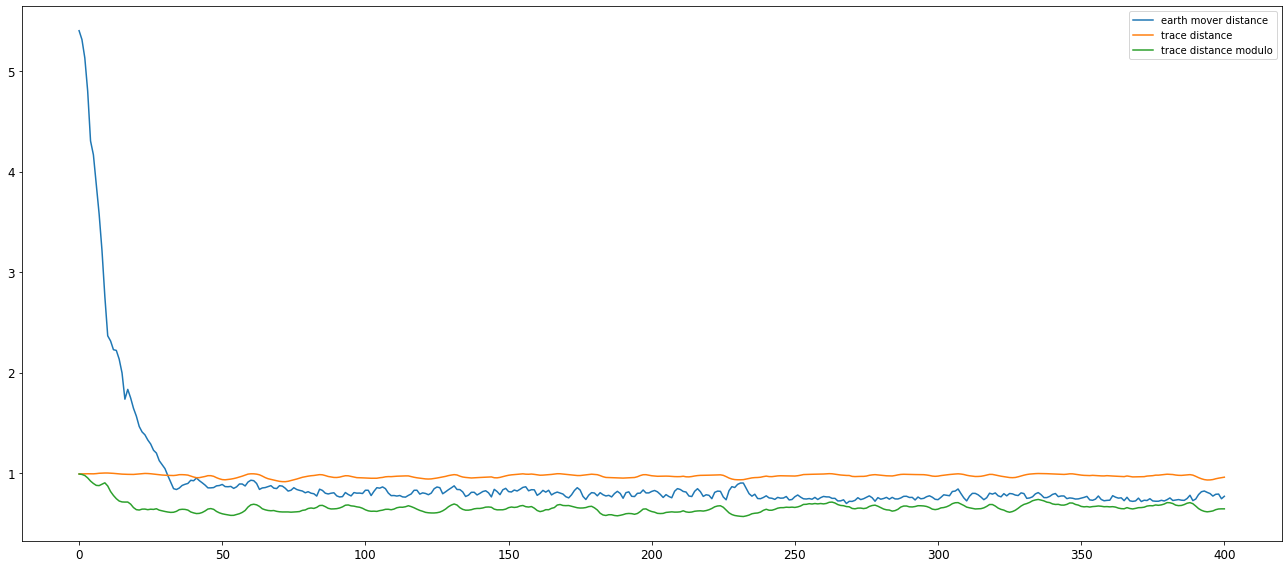

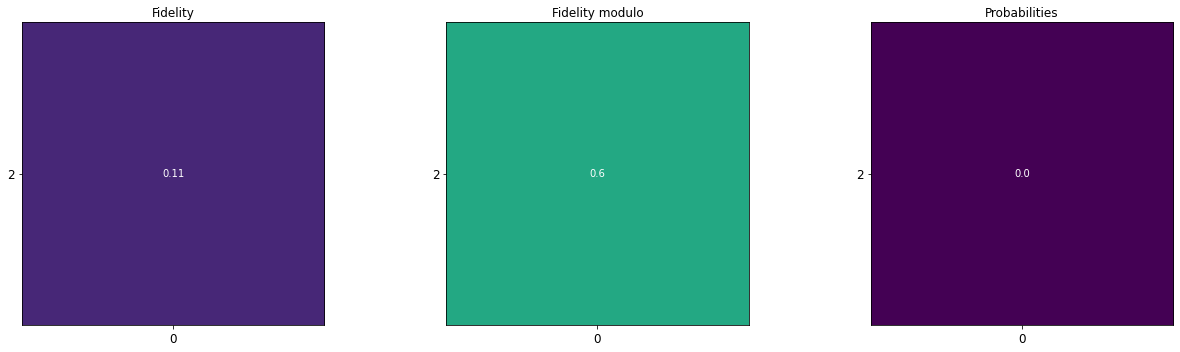

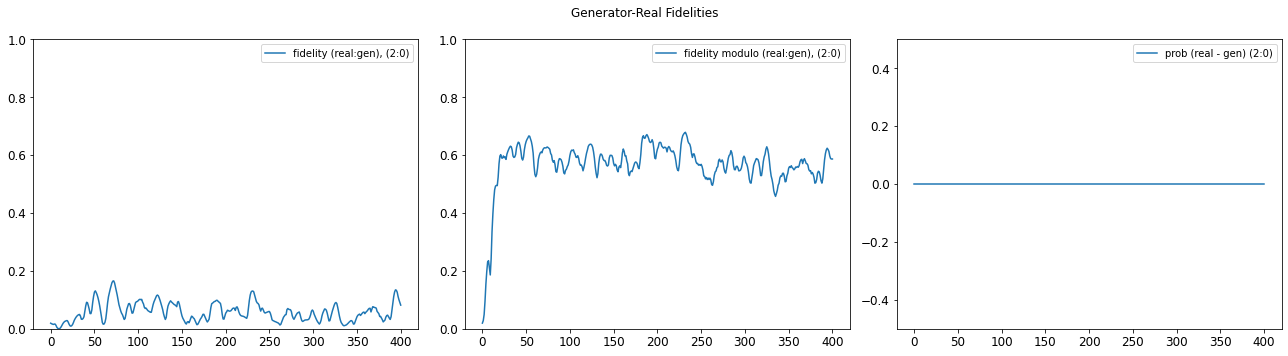

----------------------------------------------------
Epoch 400:  EM distance = 0.7681263652050001, trace distance = 0.9582269363999191, abs trace distance = 0.6431625591673054
h=Z((0, 0))*Z((0, 1)), w=0.9999987732086997, e=0.3364197611808777
h=X((0, 2))*Z((0, 3)), w=0.9999997057203883, e=0.43170714378356934
-------------------------------------
----------- TRAINING DONE -----------


In [80]:
trainers, training_results = run_for_g_values(g_values,
                     real,
                     real_symbols,
                     gen,
                     gs,
                     real_values_provider,
                     real_expectations_provider,
                     rank,
                     epochs,
                     gen_iteration, 
                     snapshot_interval_epochs,
                     description,
                     use_neptune,
                     neptune_params,
                     gan_params,
                     k)

<Figure size 432x288 with 0 Axes>

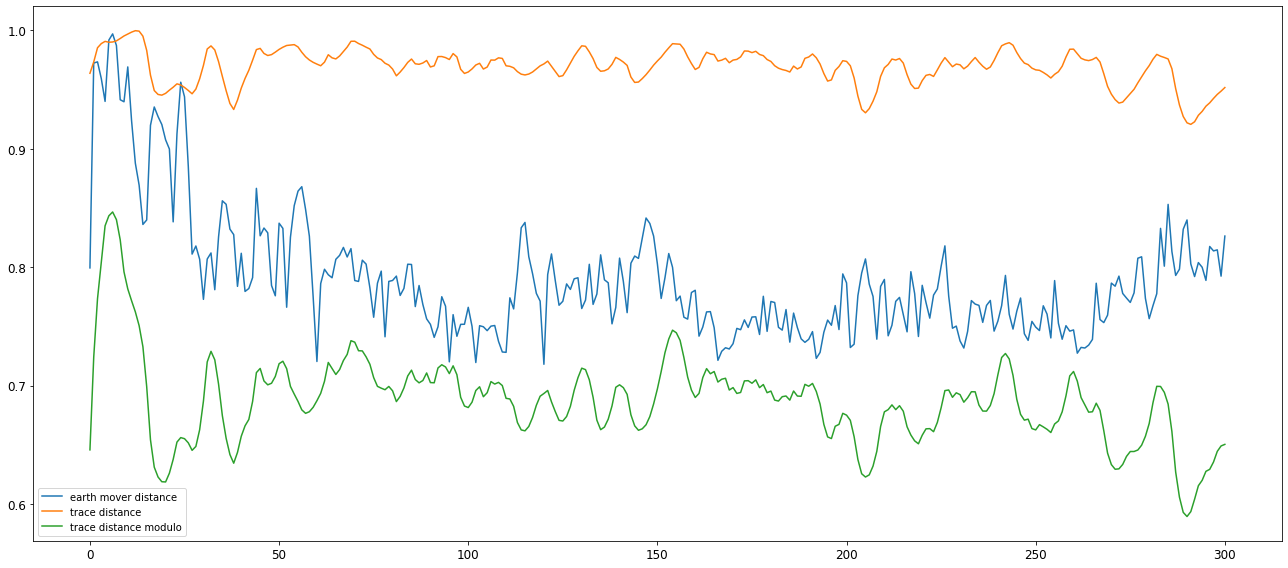

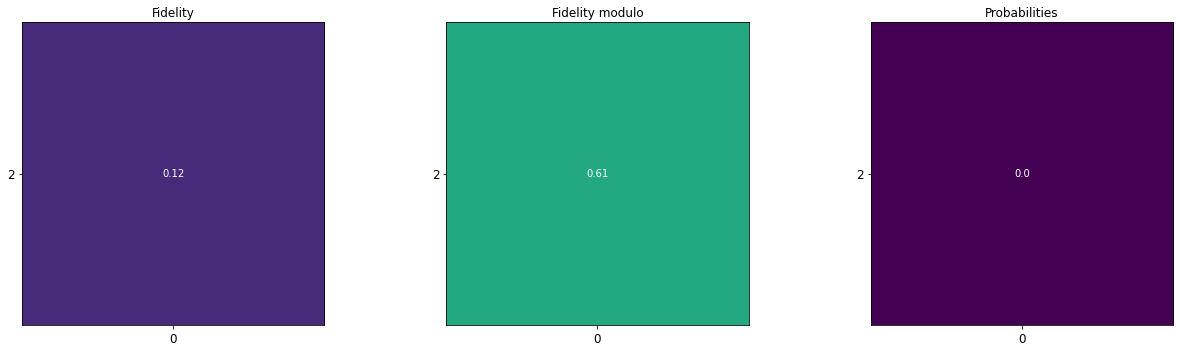

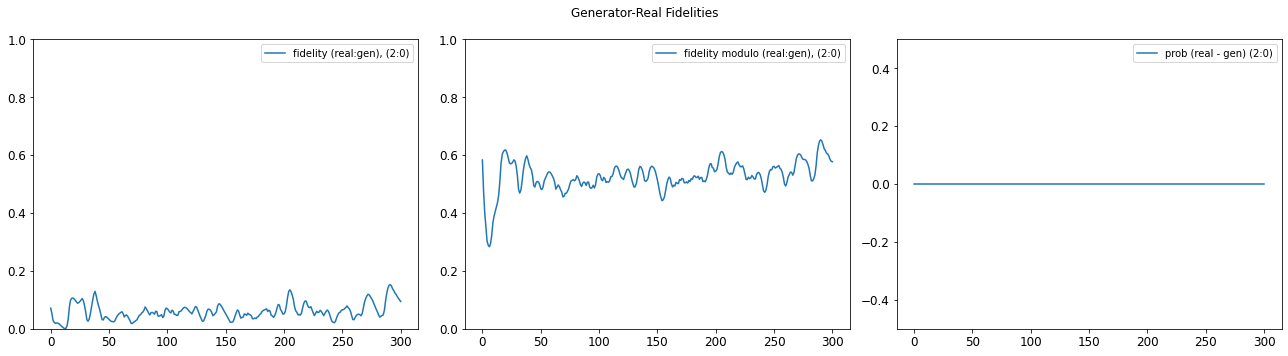

----------------------------------------------------
Epoch 300:  EM distance = 0.8262792679911524, trace distance = 0.9516660729402657, abs trace distance = 0.6504055133049407
h=Z((0, 1)), w=-0.999999991545051, e=-0.19538289308547974
h=X((0, 0)), w=-0.999999983241538, e=-0.16149446368217468
h=X((0, 2))*Z((0, 3)), w=0.9999999147368186, e=0.4694019556045532


In [ ]:
trainers, training_results = run_for_g_values(g_values,
                     real,
                     real_symbols,
                     gen,
                     gs,
                     real_values_provider,
                     real_expectations_provider,
                     rank,
                     epochs,
                     gen_iteration, 
                     snapshot_interval_epochs,
                     description,
                     use_neptune,
                     neptune_params,
                     gan_params,
                     k,
                     trainers)

In [ ]:
compute_known_states_stats(trainers[g_values[0]], known_g_values)

In [314]:
compute_generated_states_stats(trainers[g_values[0]], known_g_values)

{'min_fidelity': 0.021877799764902228,
 'min_fidelity_tuple': ('GENERATED', 356),
 'max_fidelity': 0.8216252969052675,
 'max_fidelity_tuple': ('GENERATED', 73),
 'average_fidelity': 0.25986283825138806,
 'std_fidelity': 0.14923623331194513}

In [270]:
def compute_generated_state_deviation(real_state_provider, generated_state_provider, gen_param, limit=10):
    real_expectations = real_state_provider.get_expectations_for_parameters()
    generated_expectations = generated_state_provider.get_expectations_for_parameters([gen_param])[gen_param]
    real_exps_by_string = defaultdict(list)
    for _, r_str_exp in real_expectations.items():
        for rstr, rexp in r_str_exp.items():
            if len(real_exps_by_string[rstr]) < limit:
                real_exps_by_string[rstr].append(rexp)
    real_exps_stats = {}
    for rstr, rexps in real_exps_by_string.items():
        avg, stdev = np.mean(rexps), np.std(rexps)
        stdev_distance = abs(avg - generated_expectations[rstr]) / stdev
        real_exps_stats[rstr] = (avg, stdev, generated_expectations[rstr], stdev_distance)
    return real_exps_by_string, generated_expectations, real_exps_stats
        
def exps_eventplot(real_expectations, generated_expectations, limit_real=10, limit_gen=10):
    fig, ax = plt.subplots(1, 1,  figsize=(20, 30))
    real_exps_list = list(real_expectations.values())
    gen_exps_list = list(generated_expectations.values())
    labels = list(real_exps_list[0].keys())
    gen_exps = [[[exps[l]] for l in labels] for exps in gen_exps_list]
    real_exps = [[[exps[l]] for l in labels] for exps in real_exps_list]
    lineoffsets = [3*el for el in list(range(len(real_exps[0])))]

    for i, c in enumerate(['red' for i in range(len(gen_exps)) if i < limit_gen]):  
        ax.eventplot(gen_exps[i], lineoffsets=lineoffsets, colors="red", linewidths=2)
    for i, c in enumerate(['blue' for i in range(len(real_exps)) if i < limit_real]):  
        ax.eventplot(real_exps[i], lineoffsets=lineoffsets, colors=c, linewidths=2)
    plt.yticks(lineoffsets, labels)
    plt.show()
    

In [ ]:
real_exps_by_string, generated_exp_by_string, real_exps_stats = compute_generated_state_deviation(
    trainer.real_expectations_provider.precomputed_expectations_provider,
    trainer.real_expectations_provider,
    g_values[0]
)

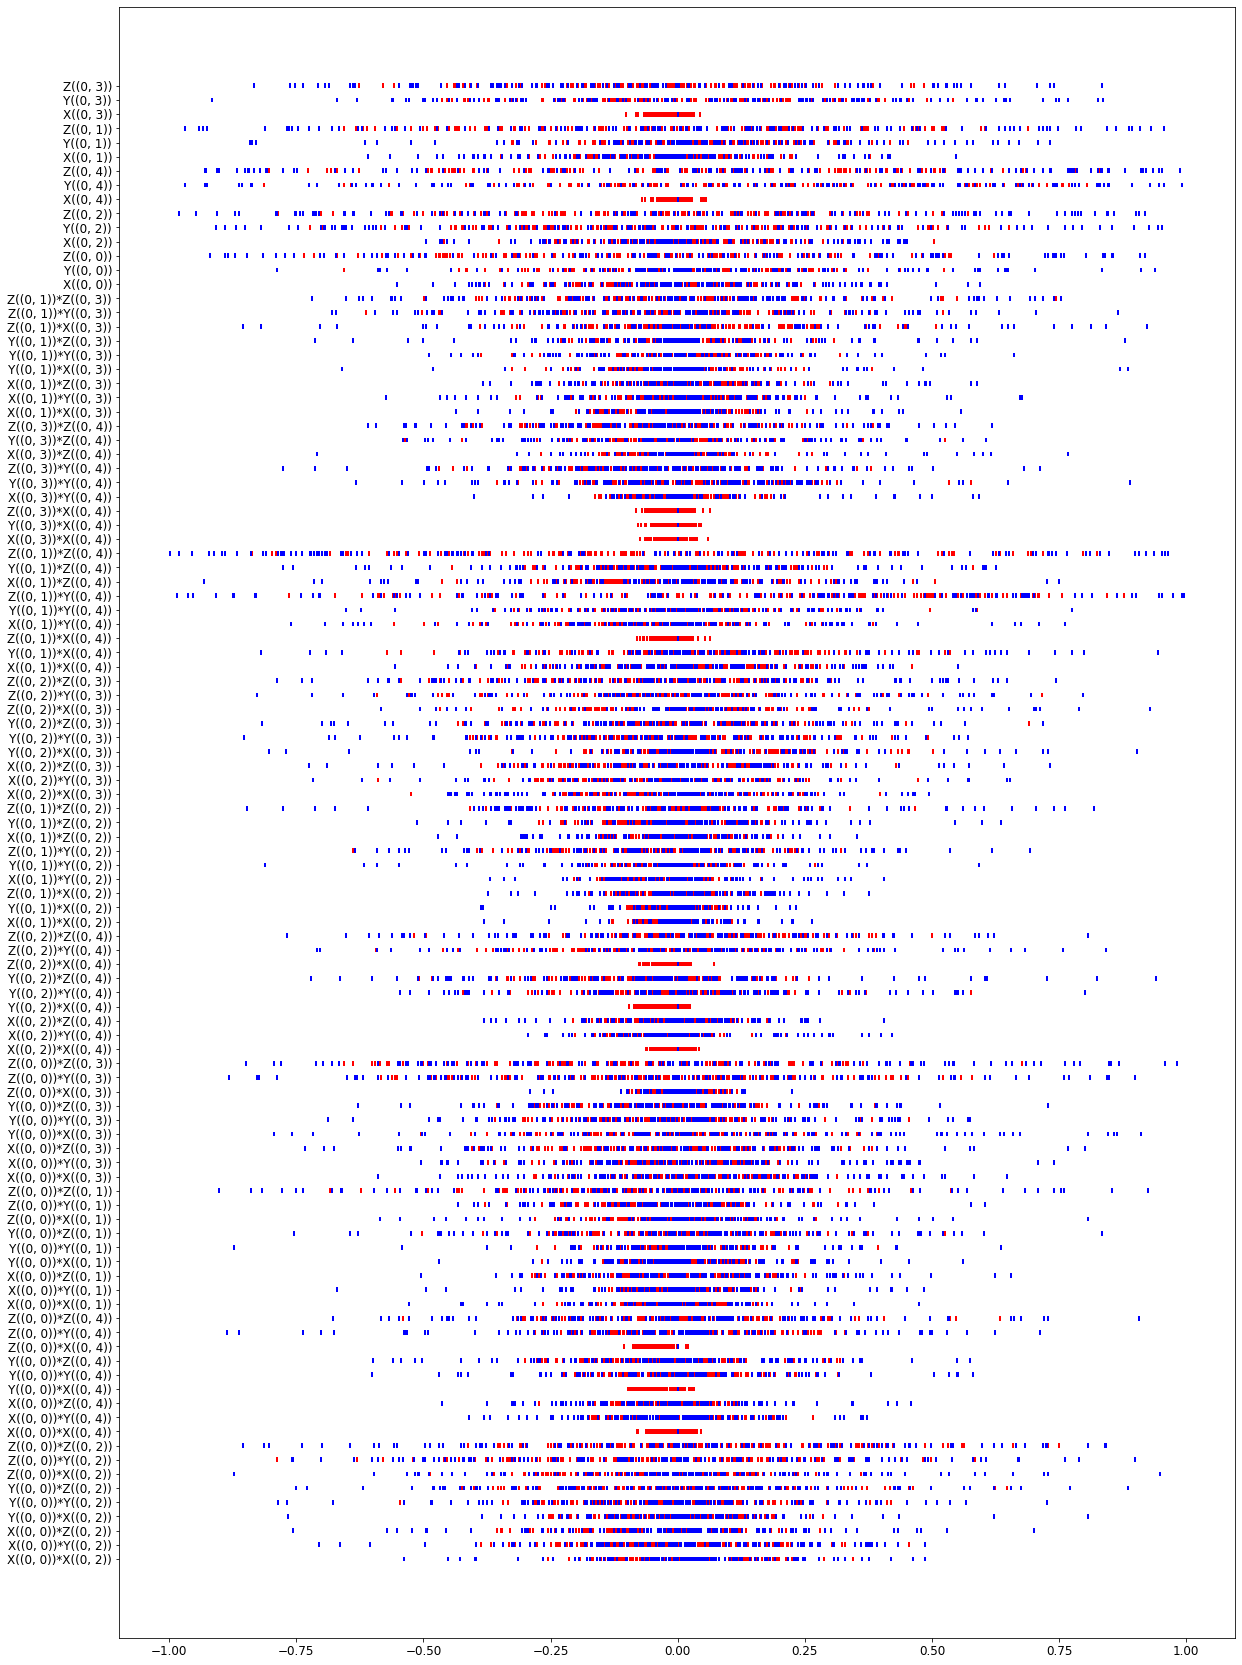

In [316]:
gen_param = g_values[0]
trainer = trainers[gen_param]
generated_exp_by_string = trainer.real_expectations_provider.get_expectations_for_parameters(list(range(128)))
real_exp_by_string = trainer.real_expectations_provider.precomputed_expectations_provider.get_expectations_for_parameters(list(range(128)))
exps_eventplot(real_exp_by_string,
               generated_exp_by_string, 128, 128)


In [ ]:
eps = 1.e-2
trainer = trainers[g_values[0]]
re_exps = trainer.real_expectations_provider.get_expectations_for_parameters([g_values[0]])[g_values[0]]
sorted({str(s): e for s, e in re_exps.items() if abs(e) > eps}.items())

In [ ]:
index = 15
trainer.real_expectations_provider.precomputed_expectations_provider.eps = eps
real_exps2 = trainer.real_expectations_provider.precomputed_expectations_provider.get_expectations_for_parameters([index], filter_small_expectations=True)[index]
real_exps2 = {str(k): v for k, v in real_exps2.items()}
sorted(real_exps2.items())

In [ ]:
gen_exps = list(zip(trainer.disc_hamiltonians, trainer.get_all_generator_expectations(trainer.disc_hamiltonians).numpy()[0]))
sorted({str(s): e for s, e in gen_exps if abs(e) > eps}.items())

In [ ]:
trainer.gen_evaluator.get_state_from_params()[1]

In [ ]:
trainer.real_evaluator.get_state_from_params(labels=0)[1]

In [ ]:
cirq.fidelity(trainer.gen_evaluator.get_state_from_params()[1], trainer.real_evaluator.get_state_from_params(labels=-0.3)[1])

In [ ]:
np.set_printoptions(suppress=True)
xd = (trainer.get_all_generator_expectations(trainer.disc_hamiltonians).numpy() - trainer.get_real_expectation(
            trainer.disc_hamiltonians)).flatten()
xd

In [ ]:
xdd = np.array([x for pair in zip(xd[0], -xd[0]) for x in pair])

In [ ]:
A = np.array([[x for pair in zip(A_i, A_i) for  x in pair] for A_i in trainer.A])

In [ ]:
from scipy.optimize import linprog
b = np.ones(len(trainer.qubit_to_string_index))
b

In [ ]:
res = linprog(-xdd, A_ub=A, b_ub=b)
res

In [ ]:
xs = [res.x[i] - res.x[i+1] for i in range(0, len(res.x), 2)]
[el if el > 0.001 else 0 for el in xs]

In [347]:
sorted(real.all_qubits())

[cirq.GridQubit(0, 0),
 cirq.GridQubit(0, 1),
 cirq.GridQubit(0, 2),
 cirq.GridQubit(0, 3),
 cirq.GridQubit(0, 4)]

Unexpected error in ping thread.
Traceback (most recent call last):
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/neptune/internal/threads/ping_thread.py", line 37, in run
    self.__backend.ping_experiment(self.__experiment)
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/neptune/internal/api_clients/hosted_api_clients/hosted_alpha_leaderboard_api_client.py", line 382, in ping_experiment
    self.leaderboard_swagger_client.api.ping(experimentId=str(experiment.internal_id)).response().result
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/bravado/http_future.py", line 239, in response
    six.reraise(*sys.exc_info())
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/six.py", line 703, in reraise
    raise value
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/bravado/http_future.py", line 200, in response
    swagger_result = self._get_swagger_resul

Unexpected error in ping thread.
Traceback (most recent call last):
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/bravado/http_future.py", line 335, in unmarshal_response
    incoming_response.swagger_result = unmarshal_response_inner(  # type: ignore
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/bravado/http_future.py", line 370, in unmarshal_response_inner
    response_spec = get_response_spec(status_code=response.status_code, op=op)
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/bravado_core/response.py", line 157, in get_response_spec
    raise MatchingResponseNotFound(
bravado_core.exception.MatchingResponseNotFound: Response specification matching http status_code 408 not found for operation Operation(ping). Either add a response specification for the status_code or use a `default` response.

During handling of the above exception, another exception occurred:

Traceback (most recent call last

Unexpected error in ping thread.
Traceback (most recent call last):
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/neptune/internal/threads/ping_thread.py", line 37, in run
    self.__backend.ping_experiment(self.__experiment)
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/neptune/internal/api_clients/hosted_api_clients/hosted_alpha_leaderboard_api_client.py", line 382, in ping_experiment
    self.leaderboard_swagger_client.api.ping(experimentId=str(experiment.internal_id)).response().result
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/bravado/http_future.py", line 239, in response
    six.reraise(*sys.exc_info())
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/six.py", line 703, in reraise
    raise value
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/bravado/http_future.py", line 200, in response
    swagger_result = self._get_swagger_resul

Unexpected error in ping thread.
Traceback (most recent call last):
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/neptune/internal/threads/ping_thread.py", line 37, in run
    self.__backend.ping_experiment(self.__experiment)
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/neptune/internal/api_clients/hosted_api_clients/hosted_alpha_leaderboard_api_client.py", line 382, in ping_experiment
    self.leaderboard_swagger_client.api.ping(experimentId=str(experiment.internal_id)).response().result
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/bravado/http_future.py", line 239, in response
    six.reraise(*sys.exc_info())
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/six.py", line 703, in reraise
    raise value
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/bravado/http_future.py", line 200, in response
    swagger_result = self._get_swagger_resul

Unexpected error in ping thread.
Traceback (most recent call last):
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/neptune/internal/threads/ping_thread.py", line 37, in run
    self.__backend.ping_experiment(self.__experiment)
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/neptune/internal/api_clients/hosted_api_clients/hosted_alpha_leaderboard_api_client.py", line 382, in ping_experiment
    self.leaderboard_swagger_client.api.ping(experimentId=str(experiment.internal_id)).response().result
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/bravado/http_future.py", line 239, in response
    six.reraise(*sys.exc_info())
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/six.py", line 703, in reraise
    raise value
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/bravado/http_future.py", line 200, in response
    swagger_result = self._get_swagger_resul

Unexpected error in ping thread.
Traceback (most recent call last):
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/neptune/internal/threads/ping_thread.py", line 37, in run
    self.__backend.ping_experiment(self.__experiment)
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/neptune/internal/api_clients/hosted_api_clients/hosted_alpha_leaderboard_api_client.py", line 382, in ping_experiment
    self.leaderboard_swagger_client.api.ping(experimentId=str(experiment.internal_id)).response().result
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/bravado/http_future.py", line 239, in response
    six.reraise(*sys.exc_info())
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/six.py", line 703, in reraise
    raise value
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/bravado/http_future.py", line 200, in response
    swagger_result = self._get_swagger_resul

Unexpected error in ping thread.
Traceback (most recent call last):
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/neptune/internal/threads/ping_thread.py", line 37, in run
    self.__backend.ping_experiment(self.__experiment)
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/neptune/internal/api_clients/hosted_api_clients/hosted_alpha_leaderboard_api_client.py", line 382, in ping_experiment
    self.leaderboard_swagger_client.api.ping(experimentId=str(experiment.internal_id)).response().result
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/bravado/http_future.py", line 239, in response
    six.reraise(*sys.exc_info())
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/six.py", line 703, in reraise
    raise value
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/bravado/http_future.py", line 200, in response
    swagger_result = self._get_swagger_resul

Unexpected error in ping thread.
Traceback (most recent call last):
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/neptune/internal/threads/ping_thread.py", line 37, in run
    self.__backend.ping_experiment(self.__experiment)
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/neptune/internal/api_clients/hosted_api_clients/hosted_alpha_leaderboard_api_client.py", line 382, in ping_experiment
    self.leaderboard_swagger_client.api.ping(experimentId=str(experiment.internal_id)).response().result
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/bravado/http_future.py", line 239, in response
    six.reraise(*sys.exc_info())
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/six.py", line 703, in reraise
    raise value
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/bravado/http_future.py", line 200, in response
    swagger_result = self._get_swagger_resul

Unexpected error in ping thread.
Traceback (most recent call last):
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/neptune/internal/threads/ping_thread.py", line 37, in run
    self.__backend.ping_experiment(self.__experiment)
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/neptune/internal/api_clients/hosted_api_clients/hosted_alpha_leaderboard_api_client.py", line 382, in ping_experiment
    self.leaderboard_swagger_client.api.ping(experimentId=str(experiment.internal_id)).response().result
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/bravado/http_future.py", line 239, in response
    six.reraise(*sys.exc_info())
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/six.py", line 703, in reraise
    raise value
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/bravado/http_future.py", line 200, in response
    swagger_result = self._get_swagger_resul

Unexpected error in ping thread.
Traceback (most recent call last):
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/neptune/internal/threads/ping_thread.py", line 37, in run
    self.__backend.ping_experiment(self.__experiment)
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/neptune/internal/api_clients/hosted_api_clients/hosted_alpha_leaderboard_api_client.py", line 382, in ping_experiment
    self.leaderboard_swagger_client.api.ping(experimentId=str(experiment.internal_id)).response().result
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/bravado/http_future.py", line 239, in response
    six.reraise(*sys.exc_info())
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/six.py", line 703, in reraise
    raise value
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/bravado/http_future.py", line 200, in response
    swagger_result = self._get_swagger_resul

Unexpected error in ping thread.
Traceback (most recent call last):
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/neptune/internal/threads/ping_thread.py", line 37, in run
    self.__backend.ping_experiment(self.__experiment)
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/neptune/internal/api_clients/hosted_api_clients/hosted_alpha_leaderboard_api_client.py", line 382, in ping_experiment
    self.leaderboard_swagger_client.api.ping(experimentId=str(experiment.internal_id)).response().result
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/bravado/http_future.py", line 239, in response
    six.reraise(*sys.exc_info())
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/six.py", line 703, in reraise
    raise value
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/bravado/http_future.py", line 200, in response
    swagger_result = self._get_swagger_resul

Unexpected error in ping thread.
Traceback (most recent call last):
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/neptune/internal/threads/ping_thread.py", line 37, in run
    self.__backend.ping_experiment(self.__experiment)
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/neptune/internal/api_clients/hosted_api_clients/hosted_alpha_leaderboard_api_client.py", line 382, in ping_experiment
    self.leaderboard_swagger_client.api.ping(experimentId=str(experiment.internal_id)).response().result
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/bravado/http_future.py", line 239, in response
    six.reraise(*sys.exc_info())
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/six.py", line 703, in reraise
    raise value
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/bravado/http_future.py", line 200, in response
    swagger_result = self._get_swagger_resul

Unexpected error in ping thread.
Traceback (most recent call last):
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/neptune/internal/threads/ping_thread.py", line 37, in run
    self.__backend.ping_experiment(self.__experiment)
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/neptune/internal/api_clients/hosted_api_clients/hosted_alpha_leaderboard_api_client.py", line 382, in ping_experiment
    self.leaderboard_swagger_client.api.ping(experimentId=str(experiment.internal_id)).response().result
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/bravado/http_future.py", line 239, in response
    six.reraise(*sys.exc_info())
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/six.py", line 703, in reraise
    raise value
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/bravado/http_future.py", line 200, in response
    swagger_result = self._get_swagger_resul

Unexpected error in ping thread.
Traceback (most recent call last):
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/neptune/internal/threads/ping_thread.py", line 37, in run
    self.__backend.ping_experiment(self.__experiment)
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/neptune/internal/api_clients/hosted_api_clients/hosted_alpha_leaderboard_api_client.py", line 382, in ping_experiment
    self.leaderboard_swagger_client.api.ping(experimentId=str(experiment.internal_id)).response().result
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/bravado/http_future.py", line 239, in response
    six.reraise(*sys.exc_info())
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/six.py", line 703, in reraise
    raise value
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/bravado/http_future.py", line 200, in response
    swagger_result = self._get_swagger_resul

Unexpected error in ping thread.
Traceback (most recent call last):
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/neptune/internal/threads/ping_thread.py", line 37, in run
    self.__backend.ping_experiment(self.__experiment)
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/neptune/internal/api_clients/hosted_api_clients/hosted_alpha_leaderboard_api_client.py", line 382, in ping_experiment
    self.leaderboard_swagger_client.api.ping(experimentId=str(experiment.internal_id)).response().result
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/bravado/http_future.py", line 239, in response
    six.reraise(*sys.exc_info())
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/six.py", line 703, in reraise
    raise value
  File "/Users/wiktorjurasz/Studies/thesis/venv/lib/python3.8/site-packages/bravado/http_future.py", line 200, in response
    swagger_result = self._get_swagger_resul